In [1]:
%cd ..

/mnt/c/Users/XCB/OneDrive - Van Oord/Documents/thesis/code


In [2]:
import pandas as pd
import geopandas as gpd
from glob import glob
import seaborn as sns
from atl_module.plotting import (
    error_lidar_pt_vs_truth_pt,
    plot_photon_map,
    plot_tracklines_overview,
)
from sklearn.metrics import r2_score
import numpy as np
from atl_module.geospatial_utils.raster_interaction import (
    query_raster,
    query_from_lines,
)
import matplotlib.pyplot as plt
from atl_module.bathymetry_extraction.refraction_correction import correct_refr
from atl_module.plotting import set_size

# aggregation functions

In [82]:
# defining some useful aggregation functions

rms_lambda = lambda x: np.sqrt(np.mean(np.square(x)))
mae_lambda = lambda x: np.mean(np.abs(x))

# this is just for by-trackline groupbys
def agg_photon_counts(arr):
    assert np.all(
        arr == arr[0]
    ), "the groupby must be by tracklines with identical values for `n_subsurf_points` and `n_total_points`"
    return arr[0]


# this dictionary can be unpacked into .agg() to create summary table with named columns. can only be used with the bathymetry points GDF since its based on the expected column names
unpackable_error_dict = {
    "RMS Error [m]": pd.NamedAgg(column="error", aggfunc=rms_lambda),
    "MAE [m]": pd.NamedAgg(column="error", aggfunc=mae_lambda),
    "Mean Error [M]": pd.NamedAgg(column="error", aggfunc=np.mean),
    # the total number of points for any grouping is the count of entries in the bathy points gdf
    # the column X, which is the latitude, its used because it always has a valid value
    "n bathy points": pd.NamedAgg(column="X", aggfunc="count"),
    # to get the number of subsurface photons, we can take the mean because it will be the same if we are averaging by site and unique trackline
    # uses a function that raises an error if the points aren't all the same
    # "n photons":pd.NamedAgg(column='n_total_points',aggfunc=agg_photon_counts),
    # "n subsurf photons":pd.NamedAgg(column='n_subsurf_points',aggfunc=agg_photon_counts)
}

# get all AOIs

In [4]:
aoidflist = []
for aoifile in glob("../data/test_sites/*/AOI.gpkg"):
    # get the name of each site
    sitename = aoifile.split("/")[3]
    df = gpd.read_file(aoifile)
    df["site"] = sitename
    aoidflist.append(df)

aoi_combined = pd.concat(aoidflist)

# get all secchi depth points

In [5]:
secchi_pt_list = []
for file in glob("../data/test_sites/*/secchi_pts.gpkg"):
    # get the name of each site
    sitename = file.split("/")[3]
    df = gpd.read_file(file)
    df["site"] = sitename
    secchi_pt_list.append(df)

secchi_pt_combined = pd.concat(secchi_pt_list).reset_index(drop=True)

secchi_pt_combined = secchi_pt_combined.assign(
    X=secchi_pt_combined.geometry.x, Y=secchi_pt_combined.geometry.y
)

# get all tracklines

In [6]:
# tracklines_dflist = [gpd.read_file(file) for file in glob('../data/test_sites/*/tracklines')]

tracklinesdflist = []
for file in glob("../data/test_sites/*/tracklines"):
    # get the name of each site
    sitename = file.split("/")[3]
    df = gpd.read_file(file)
    df["site"] = sitename
    tracklinesdflist.append(df)

tracklines_combined = pd.concat(tracklinesdflist).reset_index(drop=True)
tracklines_combined = tracklines_combined.assign(
    date=pd.to_datetime(tracklines_combined.date).dt.date
)

# Concatenate all bathymetry points from all sites

In [7]:
dflist = []
for file in glob("../data/test_sites/*/all_bathy_pts.gpkg"):
    # get the name of each site
    sitename = file.split("/")[3]
    df = gpd.read_file(file)
    df["site"] = sitename
    dflist.append(df)

bathy_pts_df = pd.concat(dflist).reset_index(drop=True).dropna()

bathy_pts_df = bathy_pts_df.assign(date=pd.to_datetime(bathy_pts_df.delta_time).dt.date)

# looking into refraction correction

<AxesSubplot:xlabel='p_vec_elev', ylabel='p_vec_az'>

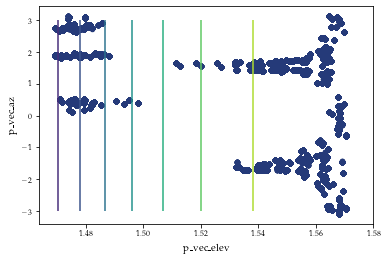

In [8]:
fig, ax = plt.subplots()

az_vecs = np.linspace(-3, 3, 1000)
elev_vecs = np.linspace(1.47, 1.58, 1000)
azgrid, elevgrid = np.meshgrid(az_vecs, elev_vecs)
xcorr, ycorr, zcorr = correct_refr(5, azgrid, elevgrid)

ax.contour(elevgrid, azgrid, zcorr)
bathy_pts_df.plot.scatter(x="p_vec_elev", y="p_vec_az", ax=ax)

In [9]:
el1 = bathy_pts_df.p_vec_elev.max()
az1 = bathy_pts_df.p_vec_az.iloc[bathy_pts_df.p_vec_elev.idxmax()]

In [10]:
correct_refr(10, el1, az1)

(7.236219752462812, 0.001997522355531652, -1.0123863696347617)

## Some stats about all the total batymetry points found

do we see a spike around 2.3 or 4.2 due to ringing?


In [11]:
# set bin edges to encapsulate the location where ringing occurs
binedges = np.arange(-25.05, 0.6, 0.1)
# 2.3 or 4.2 m

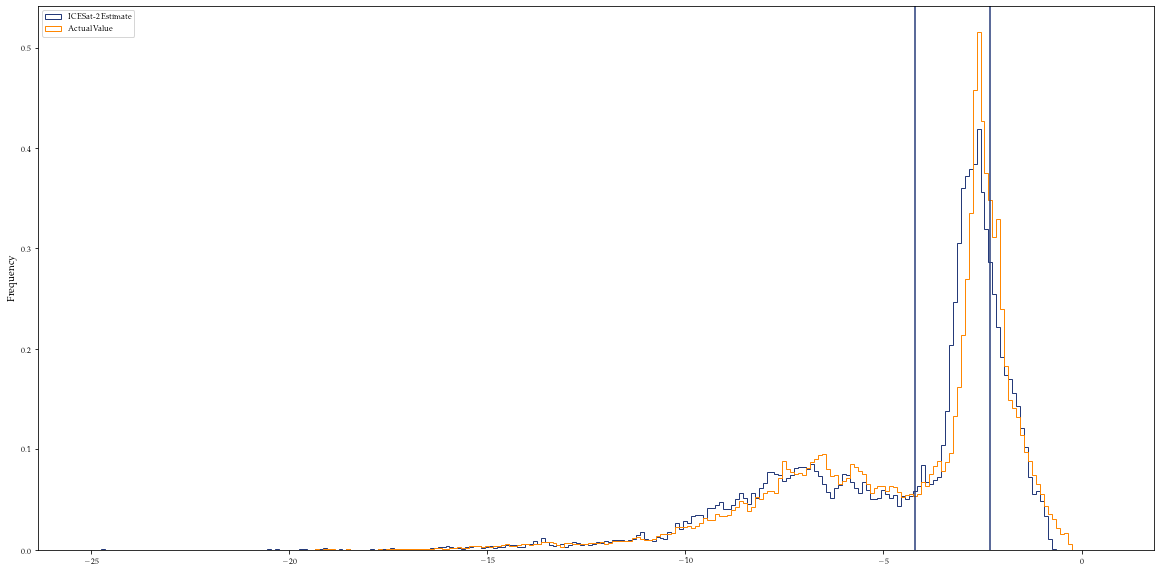

In [12]:
ax = bathy_pts_df.sf_elev_MSL.plot.hist(
    bins=binedges,
    histtype="step",
    density=True,
    label="ICESat-2 Estimate",
    figsize=(20, 10),
)
bathy_pts_df.true_elevation.plot.hist(
    ax=ax, bins=binedges, histtype="step", density=True, label="Actual Value"
)
# ax.set_xlim((-25,0))
ax.axvline(-2.3)
ax.axvline(-4.2)
ax.legend(loc="upper left")

In [13]:
error_by_site = (
    bathy_pts_df.groupby("site")
    .agg({"error": rms_lambda, "error_abs": "mean"})
    .sort_values("error")
    .round(2)
    .rename(columns={"error": "RMSE[m]", "error_abs": "MAE"})
)
error_by_site

,RMSE[m],MAE
site,,
stcroix,0.54,0.30
oahu8,0.67,0.52
oahu5,0.73,0.50
oahu4,0.75,0.57
big_island,0.78,0.51
florida_keys,0.83,0.32
charlotteamalie,1.09,0.56
oahu7,1.11,0.72
oahu1,1.16,0.77


based on the graph above we do not see significant deviation from the overall distribution of true bathymetry.

# Sites by Secchi Depth

In [14]:
secchi_pt_combined = secchi_pt_combined.assign(
    gebco_elev=query_raster(
        secchi_pt_combined.assign(
            X=secchi_pt_combined.geometry.x, Y=secchi_pt_combined.geometry.y
        ),
        "../data/GEBCO/GEBCO_2021_sub_ice_topo.nc",
    )
)
# mask out values based on GEBCO elevation
secchi_pt_combined = secchi_pt_combined[secchi_pt_combined.gebco_elev < 0]

In [15]:
zsd_date_beam = (
    secchi_pt_combined.dropna()
    .groupby(["site", secchi_pt_combined.date, "beam"])
    .median()
    .reset_index()
)

Text(0.5, 0.98, '')

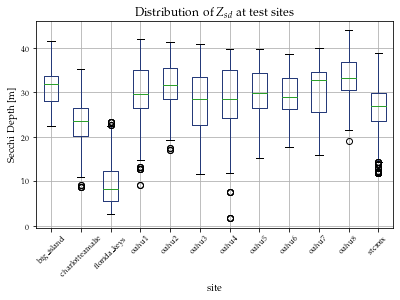

In [16]:
fig, ax = plt.subplots(figsize=set_size())
ax = secchi_pt_combined.boxplot(column="zsd", by="site", ax=ax)
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_ylabel("Secchi Depth [m]")
ax.set_title("Distribution of $Z_{sd}$ at test sites")
fig.suptitle(None)

In [17]:
fig.savefig("../document/figures/secchi_by_site_boxplot.pdf")
# fig.savefig('../document/figures/secchi_by_site_boxplot.pgf',backend='pgf')

In [18]:
secchi_pt_combined.groupby("site").median().merge(
    error_by_site, left_index=True, right_index=True
)

,zsd,sigma_zsd,diff_atten,diff_atten_unc,X,Y,gebco_elev,RMSE[m],MAE
site,,,,,,,,,
big_island,31.954956,22.590000,0.031520,31.260000,-155.932170,19.863307,-37.0,0.78,0.51
charlotteamalie,23.515282,23.920000,0.039698,29.109999,-64.911919,18.345750,-31.0,1.09,0.56
florida_keys,8.286758,56.009998,0.095968,74.010002,-80.986446,24.744184,-3.0,0.83,0.32
oahu1,29.702919,29.519999,0.033219,32.989998,-157.910539,21.276661,-40.0,1.16,0.77
oahu2,31.586966,28.969999,0.031779,32.270000,-157.679485,21.270529,-47.0,10.60,1.45
oahu3,28.434975,50.919998,0.034304,59.230000,-157.682220,21.363550,-29.0,1.24,0.46
oahu4,28.425524,27.139999,0.034313,45.480000,-157.747833,21.474975,-45.0,0.75,0.57
oahu5,29.843815,25.480000,0.033104,32.930000,-157.917571,21.672136,-34.0,0.73,0.50
oahu6,28.927444,31.820000,0.033870,32.299999,-157.987923,21.718169,-39.5,2.42,1.76


In [19]:
# tracklines_by_site = tracklines_combined.groupby(["site"]).median()
tracklines_by_site = (
    secchi_pt_combined.groupby("site")
    .median()
    .merge(error_by_site, left_index=True, right_index=True)
    .drop(columns=["X", "Y", "gebco_elev", "diff_atten", "diff_atten_unc"])
)
namelist = [
    "Big Island",
    "Charlotte Amalie",
    "Florida Keys",
    "Oahu 1",
    "Oahu 2",
    "Oahu 3",
    "Oahu 4",
    "Oahu 5",
    "Oahu 6",
    "Oahu 7",
    "Oahu 8",
    "St. Croix",
]

tracklines_by_site["Site Name"] = namelist
output_table = (
    tracklines_by_site.round(4)
    .set_index("Site Name")
    .rename(
        columns={
            "zsd": "$Zsd_{50}$[m]",
            "sigma_zsd": "$Zsd_{50}$ uncertainty",
            "diff_atten": "Median $Kd_{490}$",
            "diff_atten_unc": "median $Kd_{490}$ uncertainty",
        }
    )
)
output_table

,$Zsd_{50}$[m],$Zsd_{50}$ uncertainty,RMSE[m],MAE
Site Name,,,,
Big Island,31.9550,22.59,0.78,0.51
Charlotte Amalie,23.5153,23.92,1.09,0.56
Florida Keys,8.2868,56.01,0.83,0.32
Oahu 1,29.7029,29.52,1.16,0.77
Oahu 2,31.5870,28.97,10.60,1.45
Oahu 3,28.4350,50.92,1.24,0.46
Oahu 4,28.4255,27.14,0.75,0.57
Oahu 5,29.8438,25.48,0.73,0.50
Oahu 6,28.9274,31.82,2.42,1.76


In [20]:
output_table.to_latex(
    "../document/tables/secchi_site.tex",
    float_format="%.2f",
    escape=False,
    label="tab:ocean_color_summary_by_site",
    caption="Secchi Depth and RMSE for each test site",
)

/tmp/ipykernel_8723/2035793121.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  output_table.to_latex('../document/tables/secchi_site.tex',float_format="%.2f",escape=False,label='tab:ocean_color_summary_by_site',caption='Secchi Depth and RMSE for each test site')


# Analysis of tracklines by site
going to start from scratch

In [68]:
bathy_pts_df.groupby(["site", "date", "beam"]).agg(np.mean)

X          Y    Z_ellip    Z_geoid  \
site       date       beam                                                
big_island 2018-12-05 gt3r -155.948799  19.854967  11.019830  -8.921588   
           2019-09-29 gt3r -156.026809  19.796128  15.458242  -3.125470   
           2020-03-29 gt2r -156.030785  19.792609   5.492370 -12.998258   
           2020-06-02 gt2l -155.932414  19.856520  13.264832  -6.977752   
                      gt2r -155.933253  19.855613  12.965436  -7.267329   
...                                ...        ...        ...        ...   
stcroix    2021-12-15 gt1r  -64.847951  17.669176 -52.092978  -8.489442   
                      gt2l  -64.877354  17.669371 -52.564237  -8.872614   
                      gt2r  -64.877940  17.671653 -51.765971  -8.064654   
           2022-03-15 gt2l  -64.764100  17.672771 -58.796830 -15.271503   
                      gt3l  -64.794098  17.675380 -54.991950 -11.448654   

                            geoid_corr  tide_ocean_corr  geof2m_corr  \
site       date       beam                                             
big_island 2018-12-05 gt3r   19.857108         0.358984     0.084311   
           2019-09-29 gt3r   18.499148        -0.299604     0.084564   
           2020-03-29 gt2r   18.406048        -0.053186     0.084579   
           2020-06-02 gt2l   20.158280         0.129244     0.084304   
                      gt2r   20.148457         0.129247     0.084308   
...                                ...              ...          ...   
stcroix    2021-12-15 gt1r  -43.696786        -0.083813     0.093250   
                      gt2l  -43.784873        -0.083550     0.093249   
                      gt2r  -43.794558        -0.083550     0.093240   
           2022-03-15 gt2l  -43.618563        -0.005797     0.093236   
                      gt3l  -43.636522        -0.005993     0.093226   

                            oc_sig_conf  land_sig_conf  p_vec_az  ...  \
site       date       beam                                        ...   
big_island 2018-12-05 gt3r     1.338983       3.983051  0.228513  ...   
           2019-09-29 gt3r     1.071429       2.785714  3.105283  ...   
           2020-03-29 gt2r     1.093264       0.544041  3.058202  ...   
           2020-06-02 gt2l     2.376106       3.951327  0.160524  ...   
                      gt2r     2.611111       3.870370  0.166057  ...   
...                                 ...            ...       ...  ...   
stcroix    2021-12-15 gt1r     2.551622       3.607670  1.742342  ...   
                      gt2l     2.880562       3.956674  1.491413  ...   
                      gt2r     2.684825       3.856031  1.710539  ...   
           2022-03-15 gt2l     0.408163       0.380952  0.583314  ...   
                      gt3l     1.186241       1.077917  1.318850  ...   

                             kde_val  oc_hconf_perc  n_subsurf_points  \
site       date       beam                                              
big_island 2018-12-05 gt3r  0.159011      95.449276             232.0   
           2019-09-29 gt3r  0.231609      96.049151             197.0   
           2020-03-29 gt2r  0.110753      15.459865            2061.0   
           2020-06-02 gt2l  0.433378      95.968323             622.0   
                      gt2r  0.370803      95.790465             193.0   
...                              ...            ...               ...   
stcroix    2021-12-15 gt1r  0.180389      96.247639             984.0   
                      gt2l  0.131014      96.336958            2128.0   
                      gt2r  0.131747      96.163232             653.0   
           2022-03-15 gt2l  0.106341      51.849537            2145.0   
                      gt3l  0.116333      55.786161            5476.0   

                            n_total_points    easting_raw  northing_raw  \
site       date       beam                                                
big_island 2018-12-05 gt3r          4244.0  191153.114355  2.198133e+06   

In [83]:
error_by_transect = bathy_pts_df.groupby(["site", "date", "beam"]).agg(
    **unpackable_error_dict
)
error_by_transect

RMS Error [m]   MAE [m]  Mean Error [M]  \
site       date       beam                                            
big_island 2018-12-05 gt3r       0.677487  0.593445        0.511916   
           2019-09-29 gt3r       0.794395  0.731832       -0.731832   
           2020-03-29 gt2r       0.450566  0.405324        0.397758   
           2020-06-02 gt2l       0.479867  0.415288        0.390369   
                      gt2r       0.570529  0.431429        0.408422   
...                                   ...       ...             ...   
stcroix    2021-12-15 gt1r       1.729840  1.318498       -1.088719   
                      gt2l       0.657330  0.432050       -0.171566   
                      gt2r       0.781079  0.526942       -0.092972   
           2022-03-15 gt2l       0.993448  0.959139        0.959139   
                      gt3l       0.366866  0.294598       -0.177669   

                            n bathy points  
site       date       beam                  
big_island 2018-12-05 gt3r              59  
           2019-09-29 gt3r              42  
           2020-03-29 gt2r             193  
           2020-06-02 gt2l             226  
                      gt2r              54  
...                                    ...  
stcroix    2021-12-15 gt1r             339  
                      gt2l             854  
                      gt2r             257  
           2022-03-15 gt2l             147  
                      gt3l            2631  

[485 rows x 4 columns]

In [87]:
tracklines_combined

,file,beam,Reference,date,beam_type,total_phot,geometry,site,secchi_dep,secchi_d_1
0,processed_ATL03_20181205112951_10360107_005_01,gt1l,1036,2018-12-05,weak,891,"LINESTRING (-155.88434 19.91484, -155.88390 19...",big_island,NaN,NaN
1,processed_ATL03_20181205112951_10360107_005_01,gt1r,1036,2018-12-05,strong,4481,"LINESTRING (-155.88521 19.91326, -155.88467 19...",big_island,NaN,NaN
2,processed_ATL03_20181205112951_10360107_005_01,gt2l,1036,2018-12-05,weak,1848,"LINESTRING (-155.91730 19.85597, -155.91512 19...",big_island,NaN,NaN
3,processed_ATL03_20181205112951_10360107_005_01,gt2r,1036,2018-12-05,strong,6032,"LINESTRING (-155.91815 19.85428, -155.91596 19...",big_island,NaN,NaN
4,processed_ATL03_20181205112951_10360107_005_01,gt3l,1036,2018-12-05,weak,964,"LINESTRING (-155.94826 19.84765, -155.94743 19...",big_island,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1410,processed_ATL03_20220315201713_12761407_005_01,gt1r,1276,2022-03-15,weak,48147,"LINESTRING (-64.73909 17.62984, -64.72144 17.7...",stcroix,NaN,NaN
1411,processed_ATL03_20220315201713_12761407_005_01,gt2l,1276,2022-03-15,strong,315773,"LINESTRING (-64.76858 17.62954, -64.74916 17.8...",stcroix,NaN,NaN
1412,processed_ATL03_20220315201713_12761407_005_01,gt2r,1276,2022-03-15,weak,117079,"LINESTRING (-64.76942 17.62944, -64.75051 17.8...",stcroix,NaN,NaN
1413,processed_ATL03_20220315201713_12761407_005_01,gt3l,1276,2022-03-15,strong,380147,"LINESTRING (-64.79888 17.62915, -64.77940 17.8...",stcroix,NaN,NaN


In [44]:
final_trackline_summary = tracklines_combined.merge(
    error_by_transect, on=["site", "date", "beam"], how="left"
)

In [85]:
final_trackline_summary.replace({"n bathy points": np.NaN}, value=0)

,file,beam,Reference,date,beam_type,total_phot,geometry,site,secchi_dep,secchi_d_1,RMS Error [m],MAE [m],Mean Error [M],n bathy points
0,processed_ATL03_20181205112951_10360107_005_01,gt1l,1036,2018-12-05,weak,891,"LINESTRING (-155.88434 19.91484, -155.88390 19...",big_island,NaN,NaN,NaN,NaN,NaN,0.0
1,processed_ATL03_20181205112951_10360107_005_01,gt1r,1036,2018-12-05,strong,4481,"LINESTRING (-155.88521 19.91326, -155.88467 19...",big_island,NaN,NaN,NaN,NaN,NaN,0.0
2,processed_ATL03_20181205112951_10360107_005_01,gt2l,1036,2018-12-05,weak,1848,"LINESTRING (-155.91730 19.85597, -155.91512 19...",big_island,NaN,NaN,NaN,NaN,NaN,0.0
3,processed_ATL03_20181205112951_10360107_005_01,gt2r,1036,2018-12-05,strong,6032,"LINESTRING (-155.91815 19.85428, -155.91596 19...",big_island,NaN,NaN,NaN,NaN,NaN,0.0
4,processed_ATL03_20181205112951_10360107_005_01,gt3l,1036,2018-12-05,weak,964,"LINESTRING (-155.94826 19.84765, -155.94743 19...",big_island,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1410,processed_ATL03_20220315201713_12761407_005_01,gt1r,1276,2022-03-15,weak,48147,"LINESTRING (-64.73909 17.62984, -64.72144 17.7...",stcroix,NaN,NaN,NaN,NaN,NaN,0.0
1411,processed_ATL03_20220315201713_12761407_005_01,gt2l,1276,2022-03-15,strong,315773,"LINESTRING (-64.76858 17.62954, -64.74916 17.8...",stcroix,NaN,NaN,0.993448,0.959139,0.959139,147.0
1412,processed_ATL03_20220315201713_12761407_005_01,gt2r,1276,2022-03-15,weak,117079,"LINESTRING (-64.76942 17.62944, -64.75051 17.8...",stcroix,NaN,NaN,NaN,NaN,NaN,0.0
1413,processed_ATL03_20220315201713_12761407_005_01,gt3l,1276,2022-03-15,strong,380147,"LINESTRING (-64.79888 17.62915, -64.77940 17.8...",stcroix,NaN,NaN,0.366866,0.294598,-0.177669,2631.0


In [62]:
bathy_pts_df.groupby("beamtype").agg(**unpackable_error_dict)

,RMS Error [m],MAE [m],Mean Error [M],n bathy points
beamtype,,,,
strong,0.838451,0.352228,0.168091,353283
weak,3.069375,0.472500,0.135963,54263


In [72]:
final_trackline_summary.groupby(final_trackline_summary["n bathy points"].isna()).mean()

,total_phot,secchi_dep,secchi_d_1,RMS Error [m],MAE [m],Mean Error [M],n bathy points
n bathy points,,,,,,,
False,48522.412371,19.850662,44.673922,1.054225,0.905085,0.245819,840.301031
True,75789.487097,27.861348,31.898869,NaN,NaN,NaN,NaN
